In [1]:
# import modules
import uproot, sys, time, random, argparse, copy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import awkward as ak
from tqdm import tqdm
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter
import matplotlib.ticker as ticker
from collections import Counter
from scipy.stats import norm
from math import *

# import trackingError function
from trackingerror import Detector, inputfromfile

# Set up plot defaults
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 14.0,10.0  # Roughly 11 cm wde by 8 cm high
mpl.rcParams['font.size'] = 20.0 # Use 14 point font
sns.set(style="whitegrid")

font_size = {
    "xlabel": 17,
    "ylabel": 17,
    "xticks": 15,
    "yticks": 15,
    "legend": 13,
    "title": 13,
}

plt.rcParams.update({
    "axes.labelsize": font_size["xlabel"],  # X and Y axis labels
    "xtick.labelsize": font_size["xticks"],  # X ticks
    "ytick.labelsize": font_size["yticks"],  # Y ticks
    "legend.fontsize": font_size["legend"]  # Legend
})

In [3]:
path = '/data/jlai/iris-hep/OutputPT2/'
file = uproot.open(path + 'output_pt_10/tracksummary_ambi.root')
file['tracksummary'].keys()

['event_nr',
 'track_nr',
 'nStates',
 'nMeasurements',
 'nOutliers',
 'nHoles',
 'nSharedHits',
 'chi2Sum',
 'NDF',
 'measurementChi2',
 'outlierChi2',
 'measurementVolume',
 'measurementLayer',
 'outlierVolume',
 'outlierLayer',
 'nMajorityHits',
 'majorityParticleId',
 'trackClassification',
 't_charge',
 't_time',
 't_vx',
 't_vy',
 't_vz',
 't_px',
 't_py',
 't_pz',
 't_theta',
 't_phi',
 't_eta',
 't_p',
 't_pT',
 't_d0',
 't_z0',
 't_prodR',
 'hasFittedParams',
 'eLOC0_fit',
 'eLOC1_fit',
 'ePHI_fit',
 'eTHETA_fit',
 'eQOP_fit',
 'eT_fit',
 'err_eLOC0_fit',
 'err_eLOC1_fit',
 'err_ePHI_fit',
 'err_eTHETA_fit',
 'err_eQOP_fit',
 'err_eT_fit',
 'res_eLOC0_fit',
 'res_eLOC1_fit',
 'res_ePHI_fit',
 'res_eTHETA_fit',
 'res_eQOP_fit',
 'res_eT_fit',
 'pull_eLOC0_fit',
 'pull_eLOC1_fit',
 'pull_ePHI_fit',
 'pull_eTHETA_fit',
 'pull_eQOP_fit',
 'pull_eT_fit',
 'cov_eLOC0_eLOC0',
 'cov_eLOC0_eLOC1',
 'cov_eLOC0_ePHI',
 'cov_eLOC0_eTHETA',
 'cov_eLOC0_eQOP',
 'cov_eLOC0_eT',
 'cov_eLOC1_e

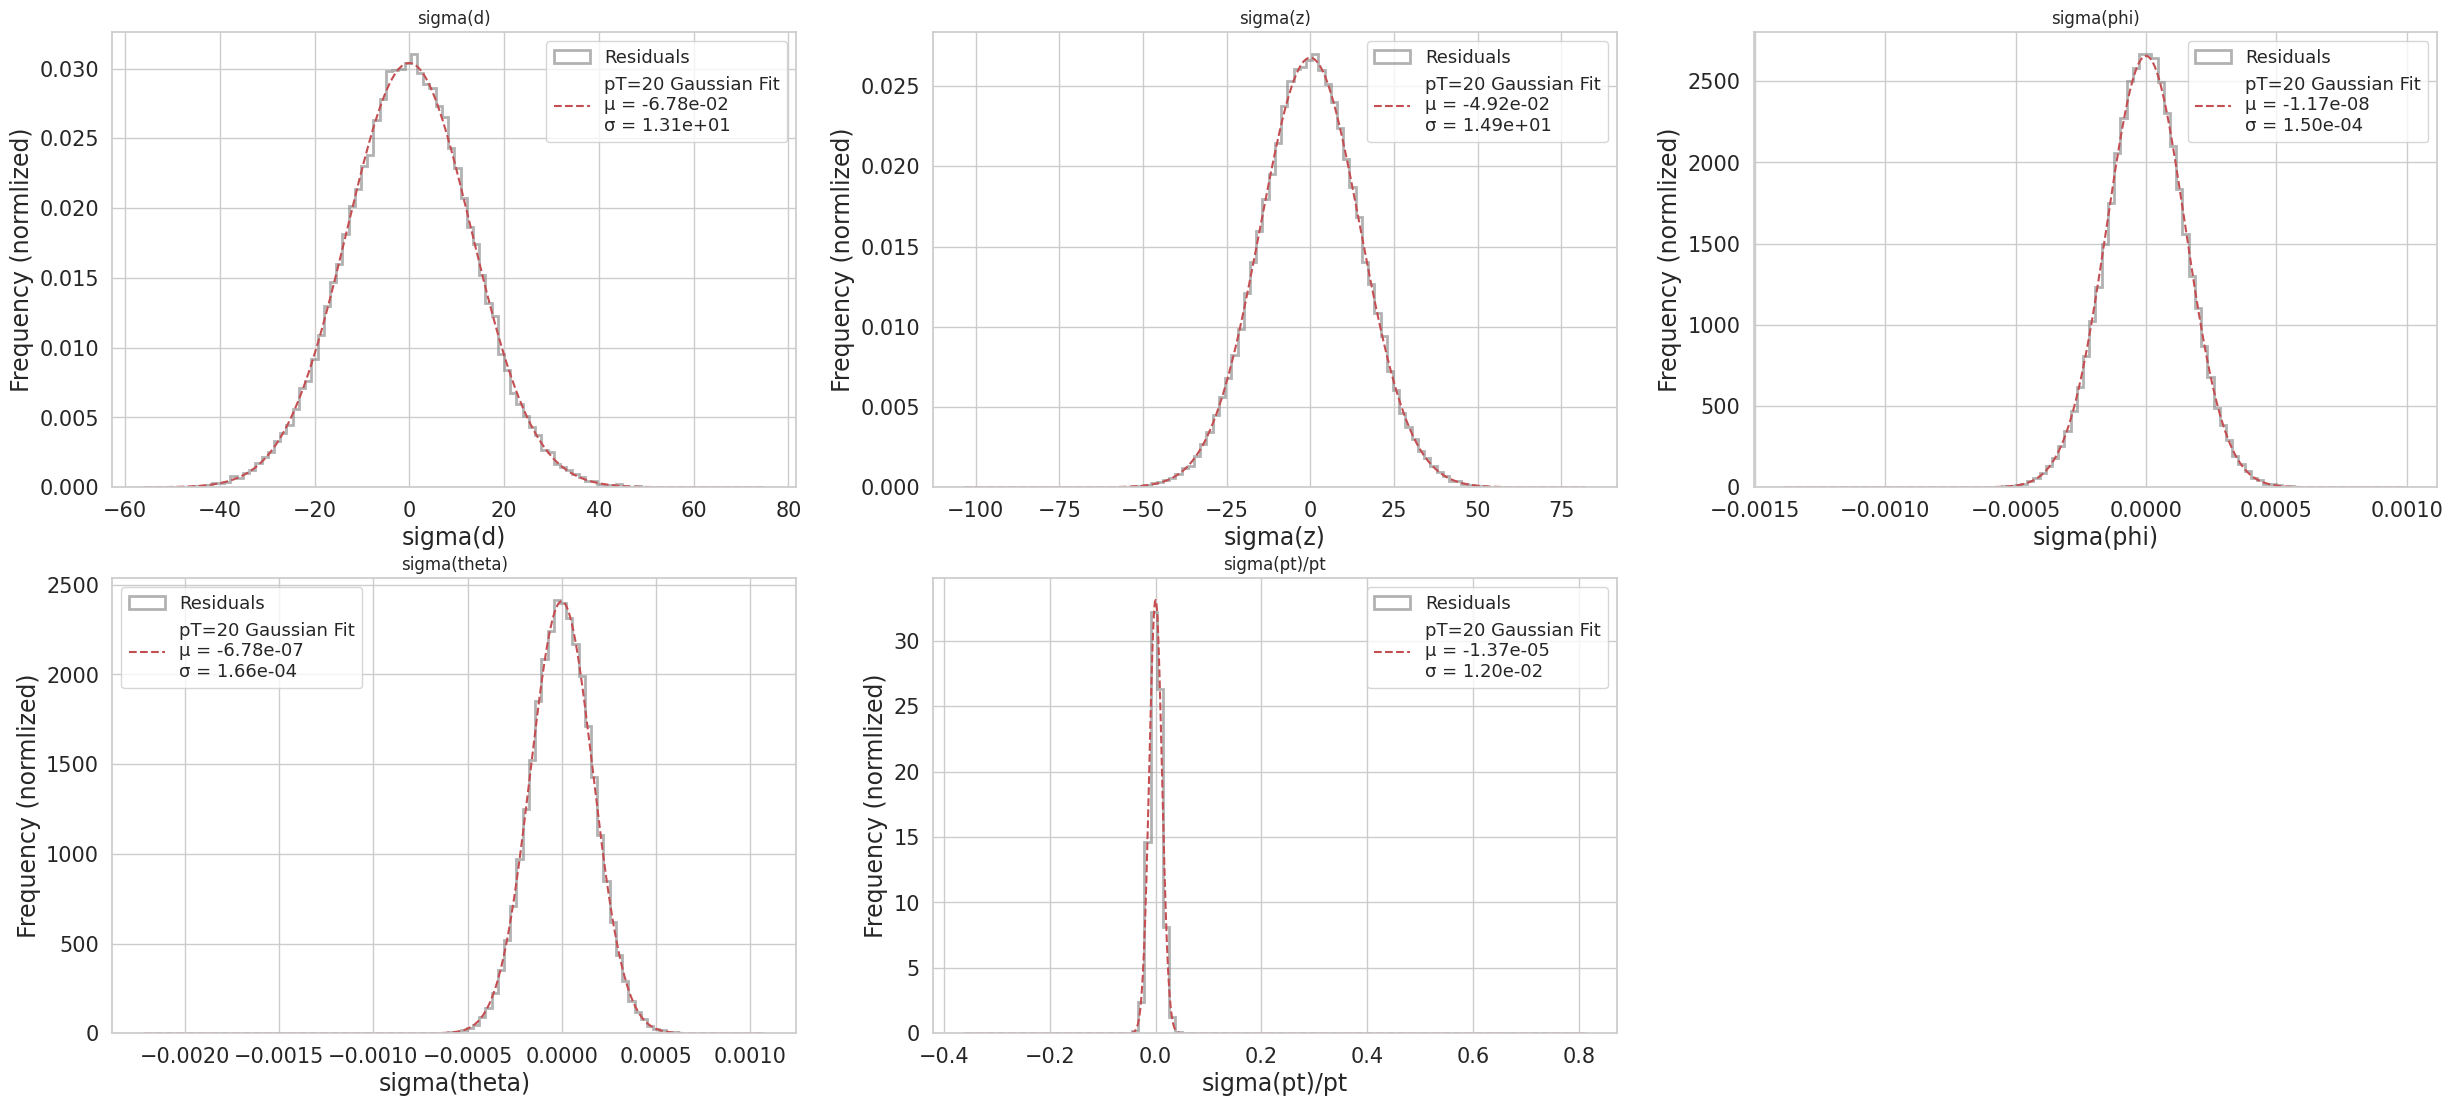

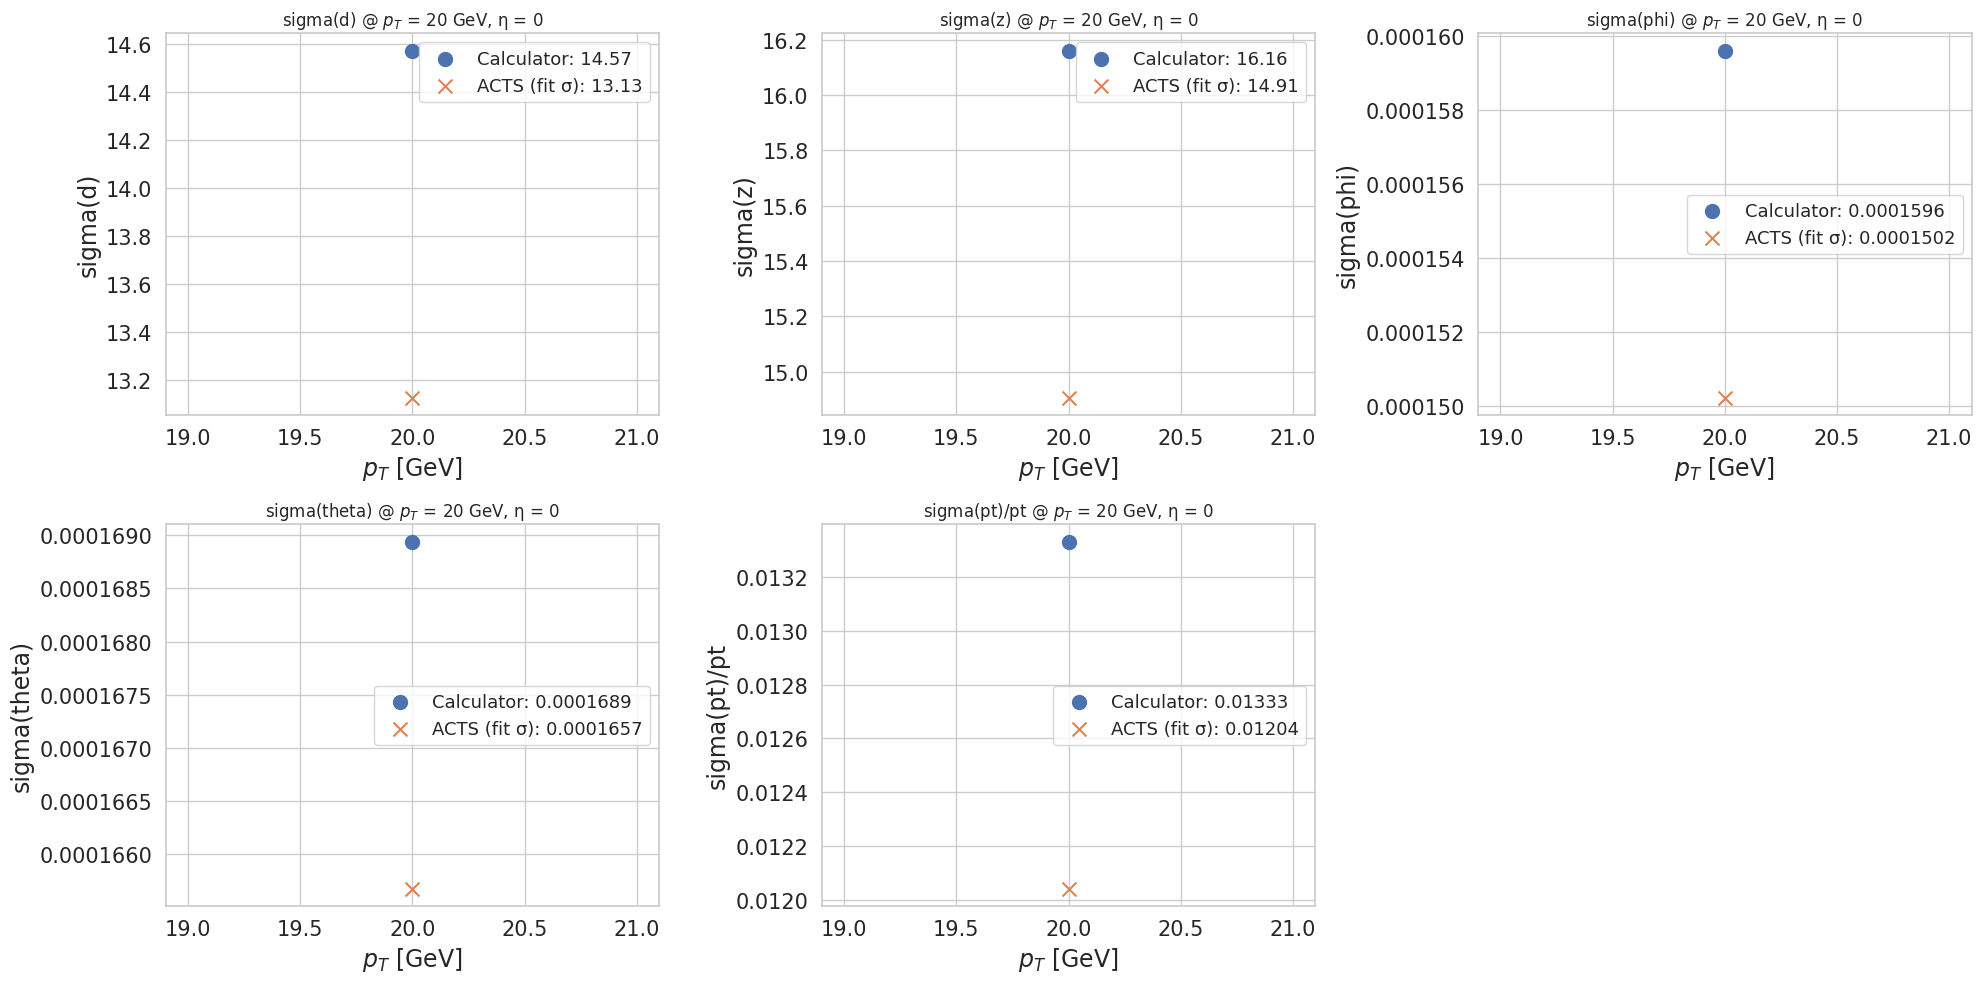

In [ ]:
path = '/data/jlai/iris-hep/OutputPT2/'
# pT_values = [1, 3, 5, 10]
pT_values = np.arange(10, 100, 10)
i = 1
file = uproot.open(path + f'output_pt_{pT_values[i]}' + '/tracksummary_ckf.root')
# file = uproot.open("/data/jlai/iris-hep/output_100000/tracksummary_ckf.root")

tree = file['tracksummary']

# < -- Fitting with no plot -- >
arrays = tree.arrays(["t_d0", "eLOC0_fit", "res_eLOC0_fit", "pull_eLOC0_fit",
                      "t_z0", "eLOC1_fit", "res_eLOC1_fit", "pull_eLOC1_fit",
                      "t_phi", "ePHI_fit", "res_ePHI_fit", "pull_ePHI_fit",
                      "t_theta", "eTHETA_fit", "res_eTHETA_fit", "pull_eTHETA_fit",
                      "t_p", "eQOP_fit", "res_eQOP_fit", "pull_eQOP_fit",
                      "t_charge"], library='ak')

pT_truth = arrays['t_p'] * np.sin(arrays['t_theta'])
pT_reco = np.abs( 1 / arrays['eQOP_fit'] ) * np.sin(arrays['eTHETA_fit'])

labels = {
    'sigma(d)': ak.flatten(arrays['res_eLOC0_fit']) * 1e3, # converting from unit mm to unit um
    'sigma(z)': ak.flatten(arrays['res_eLOC1_fit']) * 1e3, # converting to unit um
    'sigma(phi)': ak.flatten(arrays['res_ePHI_fit']),
    'sigma(theta)': ak.flatten(arrays['res_eTHETA_fit']),
    'sigma(pt)/pt': ak.flatten((pT_reco - pT_truth) / pT_truth)
}

fit_results = {}
plt.figure(figsize=(30, 13))
for key, data in labels.items():
    data = ak.to_numpy(data)
    data = data[~np.isnan(data)]

    mu, sigma = norm.fit(data)
    fit_results[key] = sigma
    
    plt.subplot(231 + list(fit_results.keys()).index(key))
    counts, bins, _ = plt.hist(data, bins=100, histtype='step', linewidth=2, density=True, alpha=0.6, color='gray', label='Residuals')

    x = np.linspace(bins[0], bins[-1], 1000)
    plt.plot(x, norm.pdf(x, mu, sigma), 'r--', label=f'pT={pT_values[i]} Gaussian Fit\nμ = {mu:.2e}\nσ = {sigma:.2e}')

    plt.title(key)
    plt.xlabel(key)
    plt.ylabel("Frequency (normlized)")
    plt.legend()
    plt.grid(True)
plt.savefig(f'/data/jlai/iris-hep-log/TrackingResolution-3.0/TrackingResolution-3.0/plots/fitted_gaussian_pT{pT_values[i]}.png')

# < -- Tracking Error Calculator -- >
p, eta = pT_values[i], 0
B, m = 2, 0.106
path = '/data/jlai/iris-hep-log/TrackingResolution-3.0/TrackingResolution-3.0/'
mydetector = inputfromfile(path+'ODD.txt', 0)
calc_result = mydetector.errorcalculation(p, B, eta, m)

# < -- plot comparsion -- >
var_labels = ['sigma(d)', 'sigma(z)', 'sigma(phi)', 'sigma(theta)', 'sigma(pt)/pt']
plt.figure(figsize=(20, 10))
for var_label in var_labels:
    idx = var_labels.index(var_label)
    plt.subplot(231 + idx)

    key = var_label
    y_calc = calc_result[var_label]
    y_acts = fit_results[key]

    plt.scatter(p, y_calc, marker='o', s=100, label=f"Calculator: {y_calc:.4g}")
    plt.scatter(p, y_acts, marker='x', s=100, label=f"ACTS (fit σ): {y_acts:.4g}")
    plt.xlabel(r"$p_T$ [GeV]")
    plt.ylabel(var_label)
    plt.title(f"{var_label} @ $p_T$ = {p} GeV, η = {eta}")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

In [2]:
path = '/data/jlai/iris-hep/OutputPT/'
file = uproot.open(path + f'output_pt_10' + '/tracksummary_ckf.root')
tree = file['tracksummary']
arrays = tree.arrays(["t_d0", "eLOC0_fit", "res_eLOC0_fit",
                "t_z0", "eLOC1_fit", "res_eLOC1_fit",
                "t_phi", "ePHI_fit", "res_ePHI_fit",
                "t_theta", "eTHETA_fit", "res_eTHETA_fit",
                "t_p", "t_pT", "eQOP_fit", "res_eQOP_fit",
                "t_charge"], library='ak')
arrays["t_d0"]

<Array [[-0.00304], [0.0127], ..., [-0.00919]] type='100000 * var * float32'>

In [3]:
path = '/data/jlai/iris-hep/OutputPT/'
var_labels = ['sigma(d)', 'sigma(z)', 'sigma(phi)', 'sigma(theta)', 'sigma(pt)/pt']

y_acts = {label: [] for label in var_labels}
y_acts_err = {label: [] for label in var_labels}

# pT_values = np.concatenate((np.linspace(1, 15, 15), np.linspace(20, 100, 9)))
pT_values = np.arange(10, 100, 10)
for pT_value in pT_values:
    pT_value = int(pT_value)
    print(f'Saving ACTS track resol with pT = {pT_value} GeV')
    file = uproot.open(path + f'output_pt_{pT_value}' + '/tracksummary_ckf.root')
    tree = file['tracksummary']

    # < -- Fitting with no plot -- >
    arrays = tree.arrays(["t_d0", "eLOC0_fit", "res_eLOC0_fit",
                        "t_z0", "eLOC1_fit", "res_eLOC1_fit",
                        "t_phi", "ePHI_fit", "res_ePHI_fit",
                        "t_theta", "eTHETA_fit", "res_eTHETA_fit",
                        "t_p", "t_pT", "eQOP_fit", "res_eQOP_fit",
                        "t_charge"], library='ak')

    pT_truth = arrays['t_p'] * np.sin(arrays['t_theta'])
    pT_reco = np.abs( 1 / arrays['eQOP_fit'] ) * np.sin(arrays['t_theta'])
    # pT_reco = np.abs( 1 / arrays['eQOP_fit'] ) * np.sin(arrays['eTHETA_fit'])

    labels = {
        'sigma(d)': ak.flatten(arrays['res_eLOC0_fit']) * 1e3, # converting from unit mm to unit um
        'sigma(z)': ak.flatten(arrays['res_eLOC1_fit']) * 1e3, # converting to unit um
        'sigma(phi)': ak.flatten(arrays['res_ePHI_fit']),
        'sigma(theta)': ak.flatten(arrays['res_eTHETA_fit']),
        'sigma(pt)/pt': ak.flatten((pT_reco - pT_truth))
    }

    plt.figure(figsize=(30, 13))
    for key, data in labels.items():
        data = ak.to_numpy(data)
        data = data[~np.isnan(data)]

        N = len(data)
        mu, sigma = norm.fit(data)
        if key == "sigma(pt)/pt":
            sigma = sigma / pT_value
        y_acts[key].append(sigma)
        y_acts_err[key].append(sigma / np.sqrt(2 * N) if N > 0 else 0)

Saving ACTS track resol with pT = 10 GeV
Saving ACTS track resol with pT = 20 GeV
Saving ACTS track resol with pT = 30 GeV
Saving ACTS track resol with pT = 40 GeV
Saving ACTS track resol with pT = 50 GeV
Saving ACTS track resol with pT = 60 GeV
Saving ACTS track resol with pT = 70 GeV
Saving ACTS track resol with pT = 80 GeV
Saving ACTS track resol with pT = 90 GeV


<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

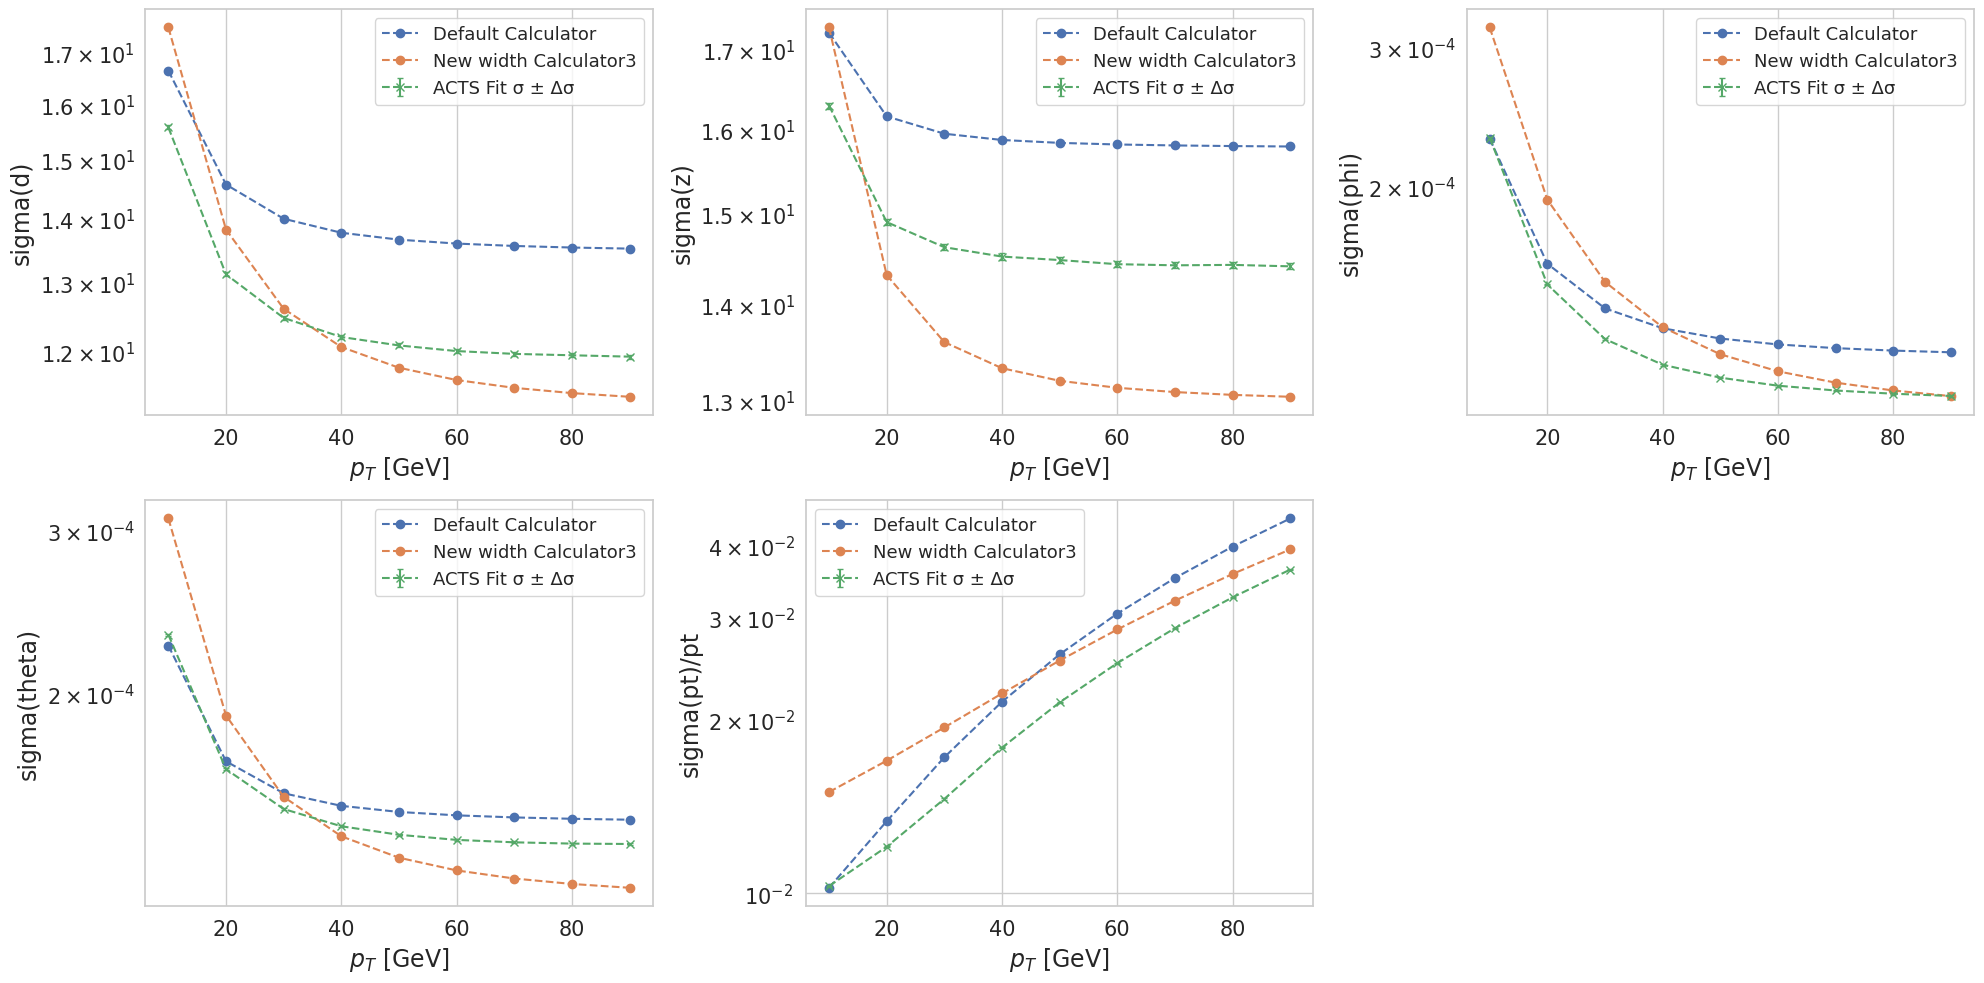

In [37]:
# < -- Tracking Error Calculator -- >
def cal(inputfile='ODD.txt'):
    y_calc = {label: [] for label in var_labels}

    for pT_value in pT_values:
        pT_value = int(pT_value)
        p, eta = pT_value, 0
        B, m = 2, 0.106
        mydetector = inputfromfile(inputfile, 0)
        calc_result = mydetector.errorcalculation(p, B, eta, m)

        for var_label in var_labels:
            y_calc[var_label].append(calc_result[var_label])
    return y_calc

path = '/data/jlai/iris-hep-log/TrackingResolution-3.0/TrackingResolution-3.0/'
y_calc = cal(path+'ODD.txt')
y_calc2 = cal(path+'myODD2.txt')
y_calc3 = cal(path+'myODD_test.txt')

# < -- plot the var vs. pT -- >
plt.figure(figsize=(20, 10))
for var_label in var_labels:
    idx = var_labels.index(var_label)
    plt.subplot(231 + idx)

    plt.plot(pT_values, y_calc[var_label], 'o--', label=f"Default Calculator")
    # plt.plot(pT_values, y_calc2[var_label], 'o--', label=f"Old width Calculator2")
    plt.plot(pT_values, np.array(y_calc3[var_label])/1.2, 'o--', label=f"New width Calculator3")
    # plt.plot(pT_values, y_acts[var_label], 'x--', label=f"ACTS (fit σ)")
    plt.errorbar(pT_values, y_acts[var_label], yerr=y_acts_err[var_label], fmt='x--', capsize=2, label="ACTS Fit σ ± Δσ")
    plt.xlabel(r"$p_T$ [GeV]")
    plt.ylabel(var_label)
    # plt.title(f"{var_label} @ $p_T$ = {p} GeV, η = {eta}")
    plt.yscale('log')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


In [22]:
5e-3 / sqrt(12)

0.0014433756729740645

In [7]:
# < -- Iterate with different width in txt file & Find the least chi2 -- >
pixel_range = np.arange(0.001, 0.1, 0.005)
short_strip_range = np.arange(0.001, 0.1, 0.005)
long_strip_range = np.arange(0.01, 1+0.05, 0.05)
best_width1, best_width2 = {}, {}
best_chi2 = float('inf')
best_diff = float('inf')

for pixel_width_value in tqdm(pixel_range):
    for short_strip_width_value in short_strip_range:
        for long_strip_width_value in long_strip_range:
            # print(f"Testing pixel width: {pixel_width_value}, short strip width: {short_strip_width_value}, long strip width: {long_strip_width_value}")

            # Write the values to the file
            odd_txt_filepath = "/data/jlai/iris-hep-log/TrackingResolution-3.0/TrackingResolution-3.0/myODD_test.txt"
            with open(odd_txt_filepath, "w") as f:
                values = [0.00227, 9999, 9999, 0.024]
                f.write(" ".join(str(v) for v in values) + "\n")

                position = [0.034, 0.07, 0.116, 0.172]
                for i in range(4):
                    values = [pixel_width_value,0.015e-3,0.015e-3,position[i]]
                    f.write(" ".join(str(v) for v in values) + "\n")

                position = [0.260, 0.360, 0.500, 0.660]
                for i in range(4):
                    values = [short_strip_width_value,0.043e-3,1.2e-3,position[i]]
                    f.write(" ".join(str(v) for v in values) + "\n")

                position = [0.840, 1.020]
                for i in range(2):
                    values = [long_strip_width_value,0.072e-3,9999,position[i]]
                    f.write(" ".join(str(v) for v in values) + "\n")

        
            # Run the tracking error calculation
            def cal(inputfile='ODD.txt'):
                y_calc = {label: [] for label in var_labels}

                for pT_value in pT_values:
                    pT_value = int(pT_value)
                    p, eta = pT_value, 0
                    B, m = 2, 0.106
                    mydetector = inputfromfile(inputfile, 0)
                    calc_result = mydetector.errorcalculation(p, B, eta, m)

                    for var_label in var_labels:
                        y_calc[var_label].append(calc_result[var_label])
                return y_calc

            y_calc = cal(odd_txt_filepath)
            diff_tmp, chi2_tmp = [], []

            # for var_label in var_labels:
            for var_label in ['sigma(d)', 'sigma(z)', 'sigma(phi)', 'sigma(theta)']:
                acts_vals = np.array(y_acts[var_label])
                acts_errs = np.array(y_acts_err[var_label])  # Used for χ²
                calc_vals = np.array(y_calc[var_label])

                # Normalize both to the max value of ACTS for fair scaling
                norm = np.max(acts_vals)
                acts_vals_norm = acts_vals / norm
                acts_errs_norm = acts_errs / norm
                calc_vals_norm = calc_vals / norm

                # Accumulate absolute difference and χ²
                diff_tmp.append(np.sum(np.abs(calc_vals_norm - acts_vals_norm)))
                chi2_tmp.append(np.sum(((calc_vals_norm - acts_vals_norm) / acts_errs_norm) ** 2))
        
            diff = np.sum(diff_tmp)
            chi2 = np.sum(chi2_tmp)

            if diff < best_diff:
                best_diff = diff
                best_width1 = {
                    'pixel': pixel_width_value,
                    'short_strip': short_strip_width_value,
                    'long_strip': long_strip_width_value
                }
            
            if chi2 < best_chi2:
                best_chi2 = chi2
                best_width2 = {
                    'pixel': pixel_width_value,
                    'short_strip': short_strip_width_value,
                    'long_strip': long_strip_width_value
                }
            



100%|██████████| 20/20 [29:31<00:00, 88.56s/it]


In [8]:
best_width1, best_width2, best_diff, best_chi2 

({'pixel': np.float64(0.011),
  'short_strip': np.float64(0.021),
  'long_strip': np.float64(0.060000000000000005)},
 {'pixel': np.float64(0.011),
  'short_strip': np.float64(0.016),
  'long_strip': np.float64(0.01)},
 np.float64(1.6914795736217545),
 np.float64(132448.10699530906))